# Q Learning simple example

In [1]:
%matplotlib inline
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import trange

In [2]:
env = gym.make("CliffWalking-v1", render_mode="rgb_array")

action_names = {0: "up", 1: "right", 2: "down", 3: "left"}
n_actions = env.action_space.n
n_states = env.observation_space.n

print(n_actions, n_states)

4 48


36 {'prob': 1}


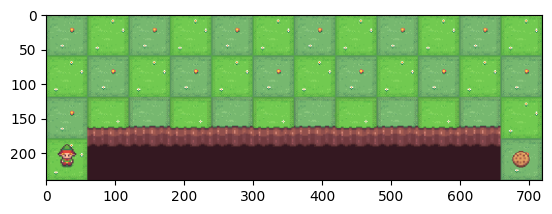

13 -1 False False {'prob': 1.0}


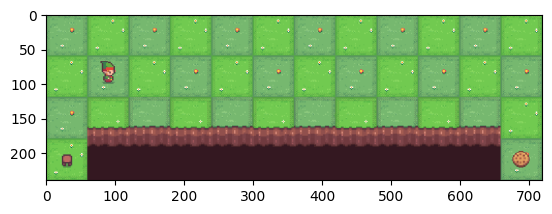

In [3]:
state, info = env.reset()
print(state, info)

image = env.render()
plt.imshow(image)
plt.show()

# up up right
env.step(0)
env.step(0)
state, reward, terminated, truncated, info = env.step(1)
print(state, reward, terminated, truncated, info)

image = env.render()
plt.imshow(image)
plt.show()

# Q Learning helper functions:

In [4]:
def select_action(Q, state, epsilon):
    # select action based on epsilon greedy policy
    action_values = Q[state]
    max_index = np.argmax(action_values)
    p = [
        1 - epsilon if i == max_index else epsilon / (n_actions - 1)
        for i in range(n_actions)
    ]
    if sum(p) != 1:
        # print('uniform!')
        # print(action_values)
        # print(p)
        s = sum(p)
        # p = [1. / action_space for i in action_values]
        p = [i / s for i in p]
    return np.random.choice(range(n_actions), p=p)

# Q Learning algorithm:

In [5]:
Q = np.zeros((n_states, n_actions), dtype=np.float32)

# parameters
gamma = 0.9
epsilon = 0.1
episodes = 10_000
max_timesteps = n_states * 3
alpha = 0.1

for e in trange(episodes):
    # play an episode
    state, info = env.reset()
    t = 0
    while True:
        action = select_action(Q, state, epsilon)
        next_state, reward, terminated, truncated, info = env.step(action)
        v = max(Q[next_state])
        # update Q function
        if terminated:
            target = reward
        else:
            target = reward + gamma * v

        # incremental update
        Q[state, action] += alpha * (target - Q[state, action])

        # step forward
        state = next_state

        if terminated:
            break

        t += 1
        if t > max_timesteps:
            break

100%|██████████| 10000/10000 [00:09<00:00, 1025.38it/s]


{0: 'up', 1: 'right', 2: 'down', 3: 'left'}


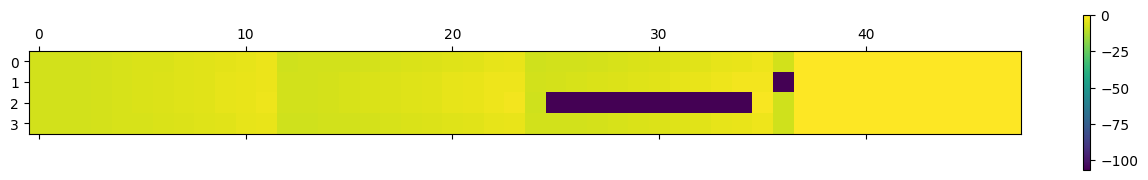

In [9]:
# plot state values
print(action_names)
mat = plt.matshow(Q.T)
cbar = plt.colorbar(mat)
plt.show()

In [7]:
# play an episode with greedy policy
state, info = env.reset()
images = [env.render()]

steps = 0
while True:
    action = Q[state].argmax()
    next_state, reward, terminated, truncated, info = env.step(action)
    images.append(env.render())
    if terminated:
        break
    state = next_state
    steps += 1
print(steps)

12


In [8]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(images[0])
ax.axis("off")


def update(i):
    im.set_data(images[i])
    return [im]


ani = FuncAnimation(fig, update, frames=len(images), interval=300, blit=True)
plt.close(fig)
HTML(ani.to_jshtml())

# DQN model

In [ ]:
class DQN_model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(2, 1024),
            nn.Tanh(),
            nn.Linear(1024, 256),
            nn.Tanh(),
            nn.Linear(256, num_classes),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x)


def init_small(m: nn.Module, std: float = 0.01):
    """
    Initialize Linear layers with N(0, std^2) weights and zero bias.
    """
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=std)
        nn.init.zeros_(m.bias)

# DQN helper functions

In [ ]:
from collections import namedtuple

import torch.nn.functional as F
from torch.utils.data import Dataset

Transition = namedtuple(
    "Transition",
    (
        "episode_number",
        "state",
        "action",
        "action_name",
        "next_state",
        "reward",
        "action_values",
        "target",
    ),
)


class ReplayMemory(Dataset):
    def __init__(
        self,
        replay_memory_size,
        num_classes,
        epsilon=0.1,
        gamma=0.9,
        max_timesteps=3 * size,
    ):
        super().__init__()

        # replay memory
        self.replay_memory = []
        self.replay_memory_size = replay_memory_size
        self.epsilon = epsilon
        self.num_classes = num_classes
        self.gamma = gamma
        self.max_timesteps = max_timesteps
        self.episode_number = 0

    def convert_state(self, state):
        x, y = state
        return torch.FloatTensor([[x, y]]) / size

    def select_action(self, action_values):
        # select action based on epsilon greedy policy
        max_value = 1 - self.epsilon
        min_value = self.epsilon / (self.num_classes - 1)
        argmax = action_values.argmax()
        p = np.ones(self.num_classes) * min_value
        p[argmax] = max_value
        return np.random.choice(range(self.num_classes), p=p)

    @torch.inference_mode()
    def play_an_episode(self, model, play_ground):
        episode_replay = []
        t = 0
        state = (0, 0)
        while True:
            action_values = model(self.convert_state(state))[0]
            new_action_values = action_values.clone()
            action = self.select_action(action_values.numpy())
            action_name = action_names[action]

            next_state = play_ground.next_state(state, action)

            r = play_ground.instant_reward(state)
            if r == play_ground.goal_score:
                print("reach the goal")
            if r == play_ground.hole_score:
                print("fall to hole")
            max_next_q = model(self.convert_state(next_state)).max()
            new_action_value = r + self.gamma * max_next_q
            new_action_values[action] = new_action_value

            episode_replay.append(
                Transition(
                    self.episode_number,
                    state,
                    action,
                    action_name,
                    next_state,
                    r,
                    action_values,
                    new_action_values,
                )
            )

            # step forward
            state = next_state
            t += 1
            if t > self.max_timesteps or play_ground.end_of_episode(next_state):
                break

        self.episode_number += 1
        return episode_replay

    def refill_reply(self, model, play_ground):
        self.replay_memory.clear()
        while len(self.replay_memory) < self.replay_memory_size:
            self.replay_memory += self.play_an_episode(model, play_ground)
        self.replay_memory = self.replay_memory[: self.replay_memory_size]

    def __len__(self):
        return len(self.replay_memory)

    def __getitem__(self, ind):
        sample = self.replay_memory[ind]
        x = self.convert_state(sample.state)[0]
        y = sample.target
        action = sample.action
        return x, y, action

# train 1

In [ ]:
my_model = DQN_model(action_space)
my_model.apply(lambda m: init_small(m, std=0.01))


rpm = ReplayMemory(256, action_space)
rpm.refill_reply(my_model, play_ground)
dataloader = DataLoader(rpm, batch_size=8, shuffle=True, num_workers=4, drop_last=False)
rpm.replay_memory

optimizer = optim.Adam(my_model.parameters(), lr=1e-3)
criterion = nn.SmoothL1Loss()

# before training
device = torch.device("cuda", index=0)
# device = torch.device("cpu")
epsilon = 0.75
t = trange(1000, desc="Epochs")
t.set_description(f"Epoch")
for e in t:
    epsilon = max(0.5, epsilon - 0.0001)
    t.set_postfix(epsilon=f"{epsilon:.4f}")

    my_model.to("cpu")
    rpm.epsilon = epsilon
    rpm.refill_reply(my_model, play_ground)
    my_model.to(device)
    for i in range(10):
        for x, target, action in dataloader:
            x = x.to(device)
            target = target.to(device)
            out = my_model(x)
            loss = criterion(out, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

my_model.cpu()

# final visualization

In [ ]:
v = np.zeros((size, size))
for x in range(size):
    for y in range(size):
        state = (x, y)
        action_values = my_model(rpm.convert_state(state)).detach().numpy()[0]
        v[x, y] = action_values.max()

mat = plt.matshow(v, origin="lower")
cbar = plt.colorbar(mat)
plt.show()

play_ground = PlayGround(size)
plt.matshow(play_ground.r, origin="lower")
plt.show()

In [ ]:
action_values

In [ ]:
# play an episode supervisely
state = (0, 0)
t = 0
while t < 3 * size:
    print("current state: {}".format(state))
    print(rpm.convert_state(state))
    action_values = my_model(rpm.convert_state(state))[0]
    print(action_values.detach())
    action = action_values.argmax().item()
    action_name = action_names[action]
    print(f"action = {action_name}")
    state = play_ground.next_state(state, action)
    t += 1
    print("-" * 40)